## 전처리 & 모듈 로드

In [2]:
from module.color_classifier import ColorClassifier

from zumi.zumi import Zumi
from zumi.util.screen import Screen
from zumi.util.vision import Vision
from zumi.protocol import Note
from threading import Thread

zumi = Zumi()
screen = Screen(False)
vision = Vision()

from module.object_tracking import ObjectTracking

from zumi.util.camera import Camera
import IPython.display
import PIL.Image
import time

camera = Camera()
objectTracking = ObjectTracking()

threshold = 100
turnSpeed = 1
forwardSpeed = 4

Starting Zumi 
Pi Zero I2C is available
Verified Pi Zero is the same
Gyroscope previously calibrated
Zumi board detected
OLED Screen detected
Gyroscope & Accelerometer detected


### <font color=red>색상 학습 & 성능 확인 - 프로젝트명 : ZumiColors</font>

In [3]:
camera.start_camera()
try:
    knn = ColorClassifier()
    train = knn.set_values()
    
    if train:
        print("데이터 수집을 시작하십시오. 중지하려면 'q'를 누르십시오.")
        cnt = int(input("한 번에 찍고 싶은 사진의 양을 입력하십시오. : "))
        while True:
            knn.add_datas(camera, cnt)
            if knn.check_enough_datas(balance=True):
                break

        knn.save_data_set()
        knn.get_accuracy()
        
finally:
    camera.close()

Starting PiCamera
프로젝트의 이름은 무엇인가요? : ZumiColors
프로젝트가 이미 존재합니다. 이 모델을 테스트 하겠습니까? (y/n) : y
Closing PiCamera


In [4]:
try:
    print("예측을 시작합니다. 'Enter 키'를 눌러서 시작하십시오!")
    camera.start_camera()
    knn.fit("hsv")
    while True:
        if input("`Enter 키`를 누르면 예측을 시작합니다. 중지하려면 'q'를 누르십시오: ") == 'q':
            break
        image = camera.capture()
        predict = knn.predict(image)
        print(predict)
        screen.draw_text(predict)
finally:
    camera.close()

예측을 시작합니다. 'Enter 키'를 눌러서 시작하십시오!
Starting PiCamera
`Enter 키`를 누르면 예측을 시작합니다. 중지하려면 'q'를 누르십시오: 
194 153 174
red
`Enter 키`를 누르면 예측을 시작합니다. 중지하려면 'q'를 누르십시오: 
70 247 131
green
`Enter 키`를 누르면 예측을 시작합니다. 중지하려면 'q'를 누르십시오: 
35 176 147
orange
`Enter 키`를 누르면 예측을 시작합니다. 중지하려면 'q'를 누르십시오: 
55 214 134
yellow
`Enter 키`를 누르면 예측을 시작합니다. 중지하려면 'q'를 누르십시오: 
113 198 133
blue
`Enter 키`를 누르면 예측을 시작합니다. 중지하려면 'q'를 누르십시오: q
Closing PiCamera


### 라인트레이서 함수 정의

In [5]:
def LineTraceFunc() :
    try:
        print('Linetrace Start')
        
        while True:
            bottom_right = zumi.read_IR('bottom_right')
            bottom_left = zumi.read_IR('bottom_left')

            if bottom_left > threshold and bottom_right > threshold :      
                zumi.control_motors(forwardSpeed,forwardSpeed*4)
        
            elif bottom_left > threshold :
                zumi.control_motors(turnSpeed,0)
        
            elif bottom_right > threshold :
                zumi.control_motors(0, turnSpeed)
        
            else :
                print('Linetrace Stop')
                zumi.stop()
                break
                
    except KeyboardInterrupt:
        print('factitious Stop')
        zumi.stop()

## Course A

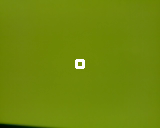

색을 인식 후 등록하였습니다.
54 229 142
yellow
Closing PiCamera
Linetrace Start
Linetrace Stop
Starting PiCamera
50 242 127
Closing PiCamera
Linetrace Start
Linetrace Stop
Linetrace Start
Linetrace Stop
Linetrace Start
Linetrace Stop


In [7]:
# 출발 시 "도 레 미" 음성 출력
zumi.play_note(Note.C4, 1000)
zumi.play_note(Note.D4, 1000)
zumi.play_note(Note.E4, 1000)

zumi.control_motors(10, 40)
time.sleep(0.5)
zumi.stop()

# 라인트레이싱
LineTraceFunc()

# 목표 주차 색상 인식 후 등록
try:
    camera.start_camera()
    
    time_out = 3 # 입력한 시간 동안 등록
    time_start = time.time()
    time_elapsed = 0
    
    print("원하는 주차장의 색상을 인식 후 등록합니다.")
    time.sleep(1)
    
    while time_elapsed < time_out:   
        time_elapsed = time.time()-time_start
                
        frame = camera.capture()    # 사진 촬영
        frame = objectTracking.register_color(frame)  # 중심점의 색상 확보
                
        IPython.display.display(PIL.Image.fromarray(frame))    
        
        print("등록 " + str(time_out - int(time_elapsed)) + " 초 전")
        IPython.display.clear_output(wait=True) 
        
    IPython.display.display(PIL.Image.fromarray(frame))
    print("색을 인식 후 등록하였습니다.") 
    
    pre = knn.predict(frame)
    print(pre)
    screen.draw_text_center(pre)
                
finally:
    camera.close()
    
# 등록된 색상과 매치되는 장소에 주차
zumi.control_motors(10, 40)
time.sleep(0.3)
zumi.stop()

for i in range(3):
    if (i % 2) == 0:
        zumi.turn_right(90)
    else:
        zumi.turn_left(90)
    
    # 라인트레이싱
    LineTraceFunc()
    
    camera.start_camera()
    
    frame = camera.capture()
    frame = objectTracking.register_color(frame)
    
    parking_color = knn.predict(frame)
    
    camera.close()
    
    # 등록된 색상의 주차 장소에 도착했을 시 1초 딜레이
    if pre == parking_color:
        zumi.stop()
        time.sleep(1)
    
    zumi.turn_right(desired_angle=180, duration=1)
    
    # 라인트레이싱
    LineTraceFunc()
    
    if (i % 2) == 0:
        zumi.turn_right(90)
    else:
        zumi.turn_left(90)
    
    zumi.control_motors(10, 40)
    time.sleep(0.3)
    zumi.stop()
    
    # 라인트레이싱
    LineTraceFunc()    
    
    if pre == parking_color:
        break

zumi.control_motors(10, 40)
time.sleep(0.5)
zumi.stop() 

# 라인트레이싱
LineTraceFunc()

## Course B

In [8]:
# 빨간색을 입력 시 정차 / 빨간색이 없을 시 주행 재개
try:
    camera.start_camera()
    knn.fit("hsv")
    
    while True:
        front_right = zumi.get_all_IR_data()[0]
        front_left = zumi.get_all_IR_data()[5]
        if front_right < 175 and front_left < 200 :
            image = camera.capture()
            predict = knn.predict(image)
            
            if predict == 'red' :
                screen.draw_text_center("RED_LIGHT")
            
            time.sleep(3)
        
        else:
            screen.clear_display()
            break

finally:
    camera.close()

zumi.forward(40, 0.5)

# 라인트레이싱
LineTraceFunc()

# 빨간색을 입력 시 정차 / 초록색을 입력 시 주행 재개
try:
    camera.start_camera()
    knn.fit("hsv")
    
    while True:
        front_right = zumi.get_all_IR_data()[0]
        front_left = zumi.get_all_IR_data()[5]
        if front_right < 175 and front_left < 200 :
            image = camera.capture()
            predict = knn.predict(image)
            if predict == 'green' :
                screen.draw_text_center("GREEN_LIGHT")
                break
        
            else:
                screen.draw_text_center("RED_LIGHT")
                
                
            time.sleep(3)

finally:
    camera.close()

zumi.forward(40, 0.5)

# 라인트레이싱
LineTraceFunc()

Starting PiCamera
146 250 194
21 111 136
195 190 200
Closing PiCamera
Linetrace Start
Linetrace Stop
Starting PiCamera
197 219 157
28 37 104
70 41 75
56 194 33
61 254 143
Closing PiCamera
Linetrace Start
Linetrace Stop


## Course C

In [9]:
# QR Code 인식
camera.start_camera()

try:
    while True:
        image = camera.capture()
        
        qr_code = vision.find_QR_code(image)

        print("message : " , vision.get_QR_message(qr_code))
        
        if vision.get_QR_message(qr_code) != None :
            ans = eval(vision.get_QR_message(qr_code))
            break

        camera.show_image(image)
        camera.clear_output()
finally:
    camera.close()
    print("done")
    
# QR Code의 message 값에 따라 갈림길 선택
zumi.control_motors(10, 40)
time.sleep(0.7)
zumi.stop()

if ans % 2 == 0:
    zumi.turn_left(90)
    
else:
    zumi.turn_right(90)
    
# 라인트레이싱
LineTraceFunc()

# 도착지점에서 미션 수행 - smile, dance
screen.happy()
for i in range(5):
    zumi.turn(360)

message :  1+2
Closing PiCamera
done
Linetrace Start
Linetrace Stop
